# Advanced Lane Finding Project
This report contains two parts: the writeup and the source code appendix. In order to keep the writeup concise, I only implemented the core code to generate results such as images. **Please note that if you want to execute the code in the writeup, please execute the source code section first.**

## Camera Calibration
First, let's apply camera calibration. All calibration images under ```camera_cal``` folder were used to calibrate the camera. ```find_corners``` method return the corners for a fiven image file. ```calibrate_camera``` method takes in a list of image files and return the camera matrix and distortion coefficients. 

Here is an example of a chessboard with identified corners drawn on it.

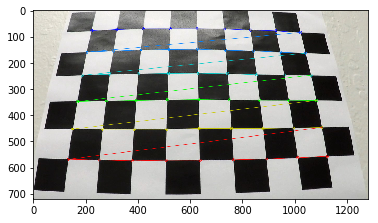

In [9]:
img_files = glob.glob('./camera_cal/calibration*.jpg')
image = mpimg.imread(img_files[13])
find_corners(image, (9,6), True);
ret, mtx, dist, rvecs, tvecs = calibrate_camera(img_files, (9,6))

## Distortion Correction
With the camera matrix and distortion coefficients, we can undistort the image ```cv2.undistort``` method. The following shows a comparison between the original and undistorted images. We can see that after applying distortion correction, the undistorted image looks fine.

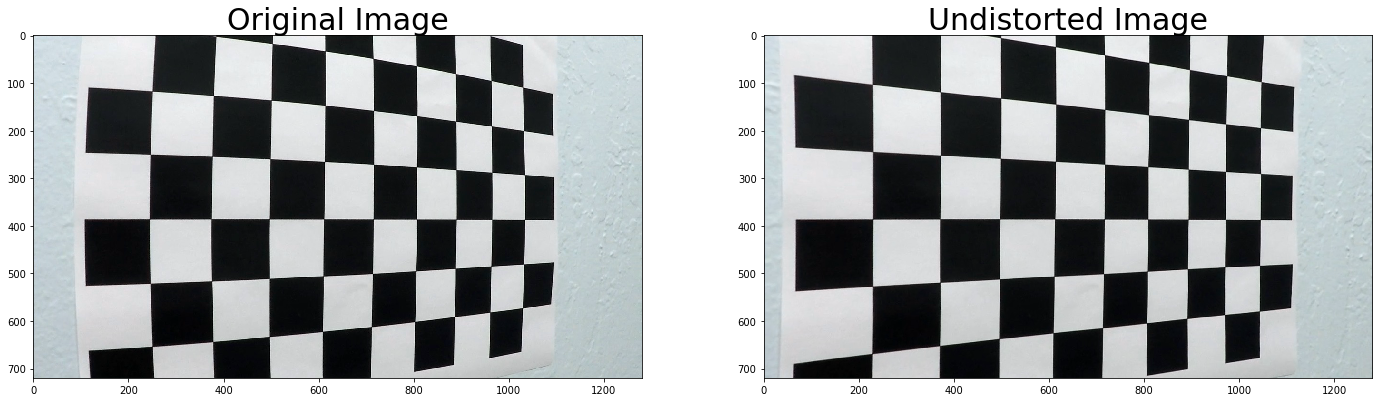

In [10]:
img = cv2.imread(img_files[15])
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Perspective Transform
The perspective transformation is implemented in the ```warp()``` method. I used the ```test_images/straight_lines2.jpg``` as the base image to get perspective transform vertices. First, I selected two points on each of the two lines of the current lane. Since from the bird-eye perspective two lane lines are parallel, it's easy to get the desired points in the transformed image.In the warped image, the two points on a straight line will have the same x-axis.

The following image show the original image with source points plotted and the warped image.

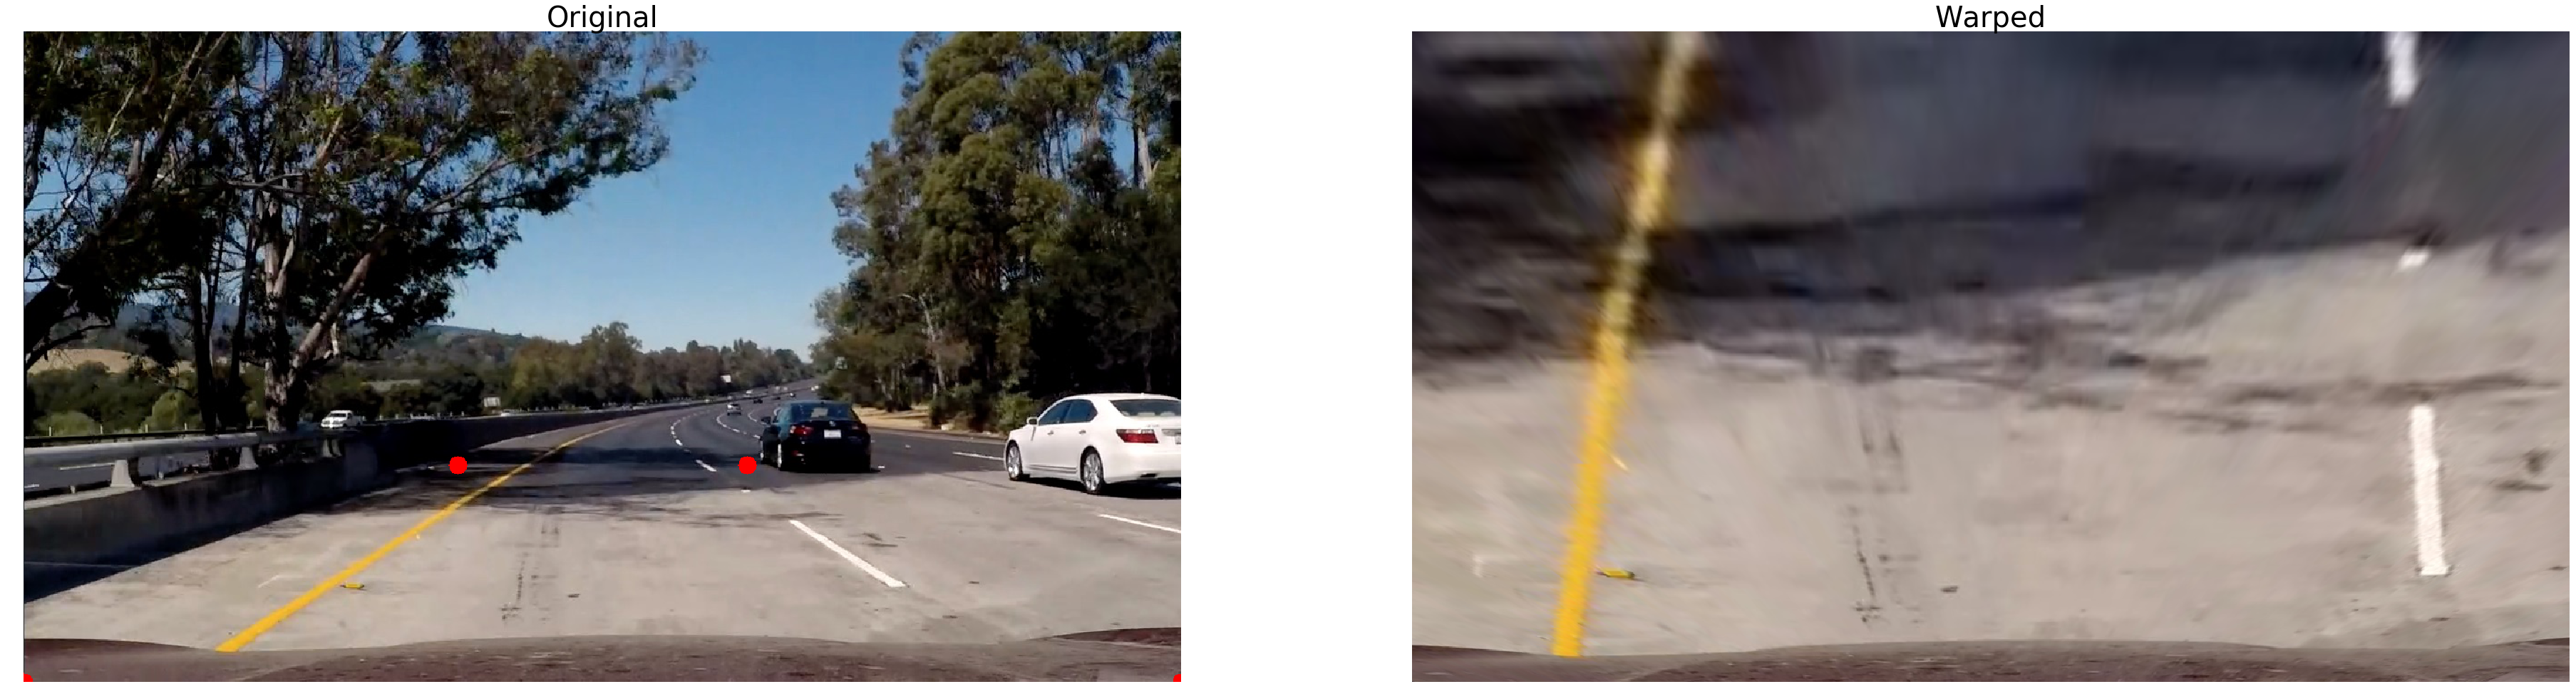

In [112]:
test_img_files = glob.glob('./test_images/*.jpg')                                            
original = mpimg.imread(test_img_files[7])
original_copy = np.copy(original)

src = np.float32(
    [[0,720],
    [1280,720],
    [800,480],
     [480,480],
    ])
dst = np.float32(
    [[0,720],
    [1280,720],
    [1280,0],
     [0,0],
    ])
for point in src:
    p = (point[0], point[1])
    cv2.circle(original_copy,p,10,(255,0,0),-1)

warped = warp(original, src, dst)
plt.figure(figsize=(64,48))

plt.subplot(1, 2, 1)
plt.title('Original',fontsize=40)
plt.axis('off')
plt.imshow(original_copy)

plt.subplot(1, 2, 2)
plt.title('Warped',fontsize=40)
plt.axis('off')
plt.imshow(warped, cmap=plt.get_cmap('gray'))

## Thresholded Binary Image
#### Color Threshold
HSV color image is used to detect yellow and white colors. Two combined thresholds of three channels is applied to the HSV image to identify lane colors. 
#### Gradient Thresholds
Sobel operator is applied to the images to get the gradients. X-gradient, Y-gradient, gradient magnitude, gradient direction are all used to threshold the image. The final thresholded image using gradient thresholds is obtained by:
```
gradient_final = (X&Y)|(Magnitude&Direction)
```
#### Putting Thresholds Together
The final thresholed image is obtained by:
```
final = （combined gradient threshold)|(color threshold)
```

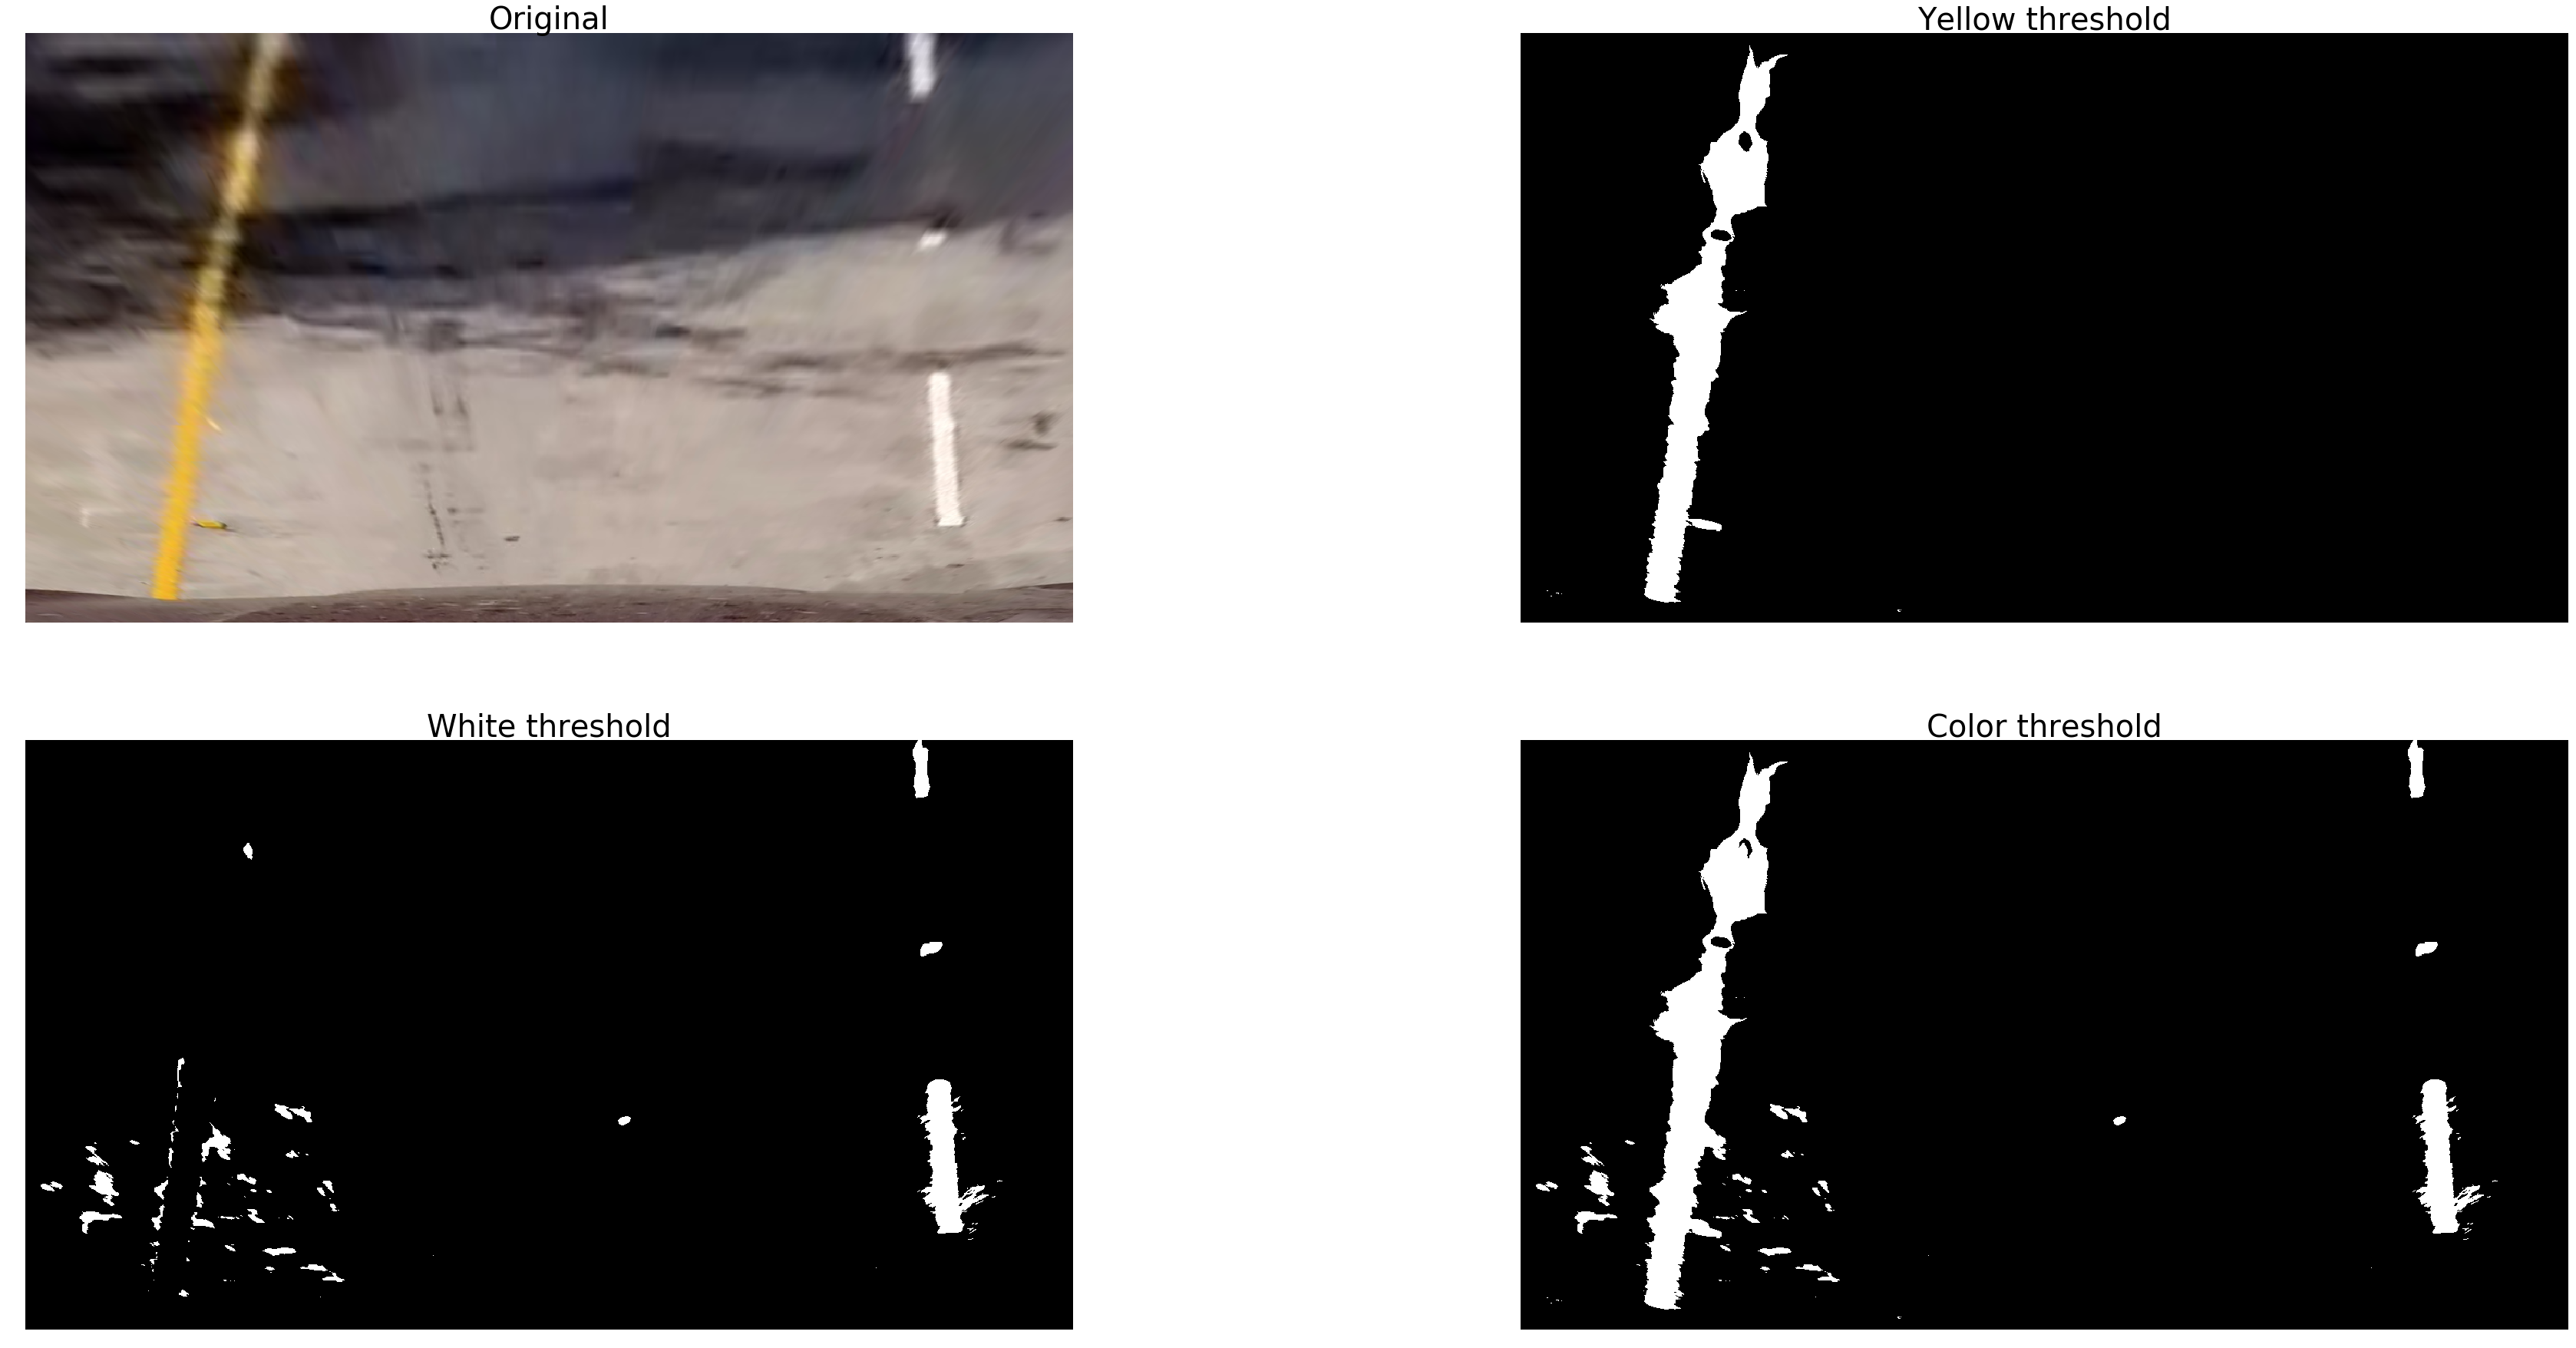

In [111]:
plt.figure(figsize=(64,48))
test_img_files = glob.glob('./test_images/*.jpg')                                            
img = mpimg.imread(test_img_files[7])
warped = warp(img, src, dst)

hsv = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

# gray = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,0]
yellow = hsv_thresh(hsv,np.array([0,90,90]),np.array([80,255,255]))
white = hsv_thresh(hsv,np.array([0,0,200]),np.array([255,90,255]))
color_thresh = cv2.bitwise_or(yellow,white)
gradx = abs_sobel_thresh(gray, orient='x', thresh=(10, 100), sobel_kernel=5)
grady = abs_sobel_thresh(gray, orient='y', thresh=(10, 100), sobel_kernel=5)
xy = cv2.bitwise_and(gradx, grady)# X&Y
mag_binary = mag_thresh(gray, (40, 100), sobel_kernel=5)
dir_binary = dir_thresh(gray, thresh=(0.7, 1.3), sobel_kernel=15)
magdir = cv2.bitwise_and(dir_binary, mag_binary)#Mag&Dir
sobel = cv2.bitwise_or(xy, magdir)

final = combined_thresh(warped)#S-channel|Sobel

plt.subplot(3, 2, 1)
plt.title('Original',fontsize=40)
plt.axis('off')
plt.imshow(warped)

plt.subplot(3, 2, 2)
plt.title('Yellow threshold',fontsize=40)
plt.axis('off')
plt.imshow(yellow,cmap=plt.get_cmap('gray'))


plt.subplot(3, 2, 3)
plt.title('White threshold',fontsize=40)
plt.axis('off')
plt.imshow(white,cmap=plt.get_cmap('gray'))

plt.subplot(3, 2, 4)
plt.title('Color threshold',fontsize=40)
plt.axis('off')
plt.imshow(color_thresh,cmap=plt.get_cmap('gray'))


# plt.subplot(3, 2, 5)
# plt.title('Sobel threshold',fontsize=40)
# plt.axis('off')
# plt.imshow(sobel,cmap=plt.get_cmap('gray'))

# plt.subplot(3, 2, 6)
# plt.title('Final',fontsize=40)
# plt.axis('off')
# plt.imshow(final,cmap=plt.get_cmap('gray'))

## Fit Polynomial
I used the **histogram with sliding window** approach introduced in this course to fit polynomial for lane lines. Related code can be found in the **Fit polynomial** section in the appendix. The image below shows the performance of the fitting function on a test image.

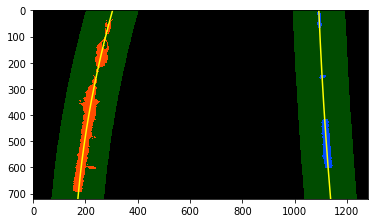

In [113]:
original = mpimg.imread(test_img_files[7])
warped = warp(original, src, dst)
binary_warped = combined_thresh(warped)
left_fit, right_fit = init_fit_lane(binary_warped)
plot_fitting(binary_warped, left_fit, right_fit)

## Curvature And Vehicle Position
Based on the polynomial coefficients of both the left and right lane lines, the ```get_curvature()``` method calculated the curvature in radius.

The ```get_position()``` method calculates the vehicle position with respect to the center of the lane. Based on the detected lane lines, the funciton calculates the center of the lane. Assuming the camera is mounted in the middle of the car, the offset of the vehicle is the difference between the center of the lane and the middle of the picture. Using a conversion factor we can then conver this difference to meters.

The ```lane()``` function takes in the original image, the binary warped image, the left and right fit polynomials and the src/dst perspective transform points to draw the detected lane onto the original image.

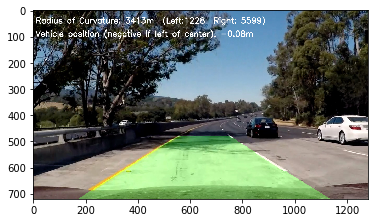

In [114]:
left_curverad = get_curvature(binary_warped.shape[0], left_fit)
right_curverad = get_curvature(binary_warped.shape[0], right_fit)
conversion =  3.7/700 # meters per pixel
position = get_position(binary_warped.shape, left_fit, right_fit, conversion)

## Draw curvature and vehicle position on the iamge
font = cv2.FONT_HERSHEY_SIMPLEX
text1 = 'Radius of Curvature: ' + "{0:.0f}".format(left_curverad/2+right_curverad/2) + 'm  (Left:' +"{0:.0f}".format(left_curverad) + '  Right: ' + "{0:.0f}".format(right_curverad) + ')' 
text2 = 'Vehicle position (negative if left of center): ' + "{0:.2f}".format(position) + 'm'
cv2.putText(original,text1,(10,50), font,1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(original,text2,(10,100), font,1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(lane(original, binary_warped, left_fit, right_fit, dst, src))

## The pipeline
Before running the pipeline, we need to first calibrate the camera. The camera matrix is then used in the pipeline to undistort images. 

Here are main steps that are involved in the pipeline:
* Undistort image
* Transform the lane to bird-eye view 
* Apply color channel and gradient thresholds to get a binary image with lanes detected
* Fit polynomial for both left and right lines
* Calculate curvatures
* Draw identified lane on original image

A ```Line``` class is defined to track the last 5 datapoints and a moving average is used. The ```init_fit_lane``` method detects the lane lines and a look-ahead filter is implemented in the ```fit_lane``` method. Based on the ```sanity_check``` method, the pipeline either fits lines from scrach or uses the look-ahead filter to save effort.

In [107]:
#####################
#Initialization steps
#####################

# Calibrate camera
img_files = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(img_files, (9,6))
# perspective transform vertices
src = np.float32(
    [[0,720],
    [1280,720],
    [800,480],
     [480,480],
    ])
dst = np.float32(
    [[0,720],
    [1280,720],
    [1280,0],
     [0,0],
    ])
# define left and right lines
n = 3 # number of frames to smooth
left = Line(n)
right = Line(n)

conversion = 3.7/700 # meters per pixel in x dimension

def sanity_check(y, fit1, fit2):
    '''
    Checks if current and previous frame detection are similar.
    1. If the x-axis(y=image height) of two polynomials differ more than 50, return false
    2. If the x-axis(y=image height/2) of two polynomials differ more than 50, return false
    3. If the coefficient of two polynomials differ more than 0.07, return false

    '''
    if (fit1==None or fit2==None):
        return True
    
    p1 = fit1[0]*y**2 + fit1[1]*y + fit1[2]
    p2 = fit2[0]*y**2 + fit2[1]*y + fit2[2]
    
    if abs(p1-p2)>50:
        return False
    
    y = 0.6*y
    p1 = fit1[0]*y**2 + fit1[1]*y + fit1[2]
    p2 = fit2[0]*y**2 + fit2[1]*y + fit2[2]
    
    if abs(p1-p2)>50:
        return False
    
    if(abs(fit1[0]-fit2[0])>0.07):
        return False
    
    return True

def pipeline(image):
    '''
    pipeline to process each video frame
    '''
    # Distortion correction
    image = cv2.undistort(image, mtx, dist, None, mtx)
    # perspective transform
    warped = warp(image, src, dst)
    
    # Apply threhold
    binary_warped = combined_thresh(warped)

    # fit poly
    if left.detected: # last frame aleady detected
        left_fit, right_fit = fit_lane(binary_warped, left.best_fit, right.best_fit)
    else: # detect lines from scratch
        left_fit, right_fit = init_fit_lane(binary_warped)
    
    position = get_position(binary_warped.shape, left_fit, right_fit, conversion)
    
    if sanity_check(binary_warped.shape[0], left_fit, left.get_last_n(0)) and sanity_check(binary_warped.shape[0], right_fit, right.get_last_n(0)):
        left.insert(binary_warped.shape[0], left_fit)
        right.insert(binary_warped.shape[0], right_fit)
        left.detected = True
        right.detected = True

    # Print curvature values
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature: ' + str(int(left.curverad/2+right.curverad/2)) + 'm  (Left:' + str(int(left.curverad)) + '  Right: ' + str(int(right.curverad)) + ')' 
    text2 = 'Vehicle position (nagative if left of center): ' + "{0:.2f}".format(position) + 'm'
    cv2.putText(image,text1,(10,50), font,1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,text2,(10,100), font,1,(255,255,255),2,cv2.LINE_AA)
    # draw lane on undistorted image
    result = lane(image, binary_warped, left.best_fit, right.best_fit, dst, src)

    return result

## Process Videos
The following code block is used to process the video using the image pipeline. The processed video is saved to ```project_video_output.mp4```.

In [ ]:
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(pipeline)
%time new_clip.write_videofile(output, audio=False)

## Discussion and Future Work
#### Dynamic Perspective Transformation
The current approach assumes the car always stays in the center of the lane. Therefore the vertices for perspective transormation are fixed pixels. However, in reality the car won't always perfectly stay in the center. A more intelligent algorithm is required to dynamically detect the vertices. 
#### Remove Noises
The current approaches uses a bunch of thresholds to detect edges and then use sliding histogram to detect the lines. If there are noises that are very similar to the lines, such as 
two different colors of the road surface in a single lane in the challenge video, the detection is biased. To overcome this, we can use color or position information to filter out the noise. Since lane lines are usually white, red or yellow, we can ignore those lines that have a different color. Also, we can also detect the noisy line is in the middle of the image so we can remove it.
#### More Robust Pipeline
So far we have been looking at car driving in relatively ideal situations. Weather (rain, snow), road condition (e.g. ice on the road), shades, etc., can significantly impact the current approach. More computer vision techniques can be applied to remove these noises. Also, a hubrid approach with machine learning + computer vision may be intresting to explore.

# Appendix: Python functions used in this project

In [2]:
# All required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import math
import glob
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera calibration and image undistortion

In [3]:
def find_corners(img, corner_shape, should_plot=False):
    '''
    Find corners of a chessboard
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, corner_shape, None)
    if ret & should_plot:
        img = cv2.drawChessboardCorners(img, corner_shape, corners, ret) 
        plt.imshow(img)
            
    return ret, corners

def calibrate_camera(img_files, corner_shape):
    '''
    Calibrate camera based on a list of chessboard images
    '''
    obj_points = [] #3D points in real world space
    img_points = [] #2D points in image plane

    objp = np.zeros((corner_shape[0]*corner_shape[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:corner_shape[0], 0:corner_shape[1]].T.reshape(-1,2)

    for file in img_files:
        img = mpimg.imread(file)
        ret, corners = find_corners(img, corner_shape)
        if ret:
            img_points.append(corners)
            obj_points.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[:2][::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

## Image thresholding

In [81]:
def to_unit8(img):
    return np.uint8(255*img/np.max(img))

def abs_sobel_thresh(gray, orient='x', thresh=(0, 255), sobel_kernel=3):
    '''
    x/y direction gradient threshold
    '''
    # if 'x', then cv2.Sobel(gray, cv2.CV_64F, 1, 0), if 'y', cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, abs(ord(orient)-ord('y')), abs(ord(orient)-ord('x')))
    sobel = np.absolute(sobel)
    sobel = to_unit8(sobel)                                      
    return binary(sobel, thresh)

def mag_thresh(gray, thresh=(0, 255), sobel_kernel=3):
    '''
    Gradient magnatitude threshold
    '''
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    gradmag =  to_unit8(gradmag) 
                                            
    return binary(gradmag, thresh)


def dir_thresh(gray, thresh=(0, np.pi/2), sobel_kernel=3):
    '''
    Gradient direction threshold
    '''
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    return binary(absgraddir, thresh)

def hls_thresh(img, thresh=(0,255), channel=2):
    '''
    HLS s-channel threshold
    '''
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel_img = hls[:,:,channel]
    return binary(channel_img, thresh)

def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def hsv_thresh(hsv,low,high):
    return cv2.inRange(hsv, low, high)

def combined_thresh(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = hsv_thresh(hsv,np.array([0,100,120]),np.array([80,255,255]))
    white = hsv_thresh(hsv,np.array([0,0,210]),np.array([255,80,255]))
    color_thresh = cv2.bitwise_or(yellow,white)
    return color_thresh
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
#     gradx = abs_sobel_thresh(gray, orient='x', thresh=(10, 100), sobel_kernel=5)
#     grady = abs_sobel_thresh(gray, orient='y', thresh=(10, 100), sobel_kernel=5)
#     xy = cv2.bitwise_or(gradx,grady)
#     mag_binary = mag_thresh(gray, (30, 100), sobel_kernel=5)
#     dir_binary = dir_thresh(gray, thresh=(0.7, 1.3), sobel_kernel=15)
#     magdir = cv2.bitwise_and(dir_binary, mag_binary)#Mag&Dir
#     sobel = cv2.bitwise_or(xy, magdir)
#     final = cv2.bitwise_or(sobel, color_thresh)#S-channel|Sobel
#     return final

## Perspective transform

In [5]:
def warp(img, src, dst):
    '''
    Perform perspective transformation
    '''
    img_size = (img.shape[1], img.shape[0])
   
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

## Fit polynomial

In [6]:
def init_fit_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def fit_lane(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def get_position(shape, left_fit, right_fit, conversion):
    '''
    Calculates the position of the vehicle with respect to the middle of the lane
    Return positive distance of vehicle is to the left of the middle
    '''
    y = shape[0] - 1
    left = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    offset = (shape[1] - left - right)/2
    
    return offset*conversion

def get_plotting_values(height, fit):
    ploty = np.linspace(0, height-1, height)
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return ploty, fitx
    
def plot_fitting(binary_warped, left_fit, right_fit):
    ploty, left_fitx = get_plotting_values(binary_warped.shape[0], left_fit)
    ploty, right_fitx = get_plotting_values(binary_warped.shape[0], right_fit)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

## Calculate curvature

In [7]:
def get_curvature(height, fit):
    ploty, fitx = get_plotting_values(height, fit)
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return curverad

## Draw lane on original image

In [8]:
def lane(original_image, warped, left_fit, right_fit, src, dst):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty, left_fitx = get_plotting_values(warped.shape[0], left_fit)
    ploty, right_fitx = get_plotting_values(warped.shape[0], right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space
    M = cv2.getPerspectiveTransform(src, dst)
    newwarp = cv2.warpPerspective(color_warp, M, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

## The Line() helper class

In [102]:
class Line():
    def __init__(self, n):
        # the count of current frame
        self.frame_count = -1
        # number of frames to do the moving average
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # last n fits
        self.last_n_fits = [None]*n
        #radius of curvature of the line in some units
        self.curverad = None 
    
    def insert(self, height, fit):
        self.frame_count += 1
        self.last_n_fits[self.frame_count%self.n] = fit
#         self.best_fit = fit
        if self.frame_count >= self.n:
            self.best_fit = np.average(self.last_n_fits, axis=0)
        else:
            self.best_fit = np.average(self.last_n_fits[:self.frame_count+1], axis=0)
        self.curverad = get_curvature(height, self.best_fit)
    def get_last_n(self, n):
        count = max(self.frame_count-n, 0)
        return self.last_n_fits[count%self.n]